<a href="https://colab.research.google.com/github/tomishing/python_data_science_basics/blob/main/telemarketing_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

abstract

# Porject Proposal

## Background

A bank aims to increase the number of bank term deposit and would like to know the effect of telemarketing on it and predict the success of this method. The objective is to build a robust model that can predict which clients are likely to subscribe, enabling the bank to target potential customers more effectively through telemarketing.

### Questions

1. What variables are strongly associated with the success of telemarketing?
2. How accurately can we predict which clients are likely to subscribe?

## Method
The performance of several classification algorithms are compared to indentify the most accurate and efficient model for predicting potential subscribers. The models to be evaluated include:

- Logistic Regression
- Rondom Forest,
- SVC,
- Neural Network,
- XGBoost

The best-performing model is selected based on prediction accuracy and other relevant evaluation metrics.

The reason for choosing XGBoost over AdaBoost and traditional Gradient Boosting is its relatively efficient memory usage and faster training speed. Additionally, XGBoost offers more effective mechanisms for handling overfitting.

While CatBoost is generally considered the best model for analyzing categorical data, its use is postponed in this project since all categorical variables are converted into dummy variables.

- Reference
  - [GradientBoosting vs AdaBoost vs XGBoost vs CatBoost vs LightGBM (Geeksforgeeks)](https://www.geeksforgeeks.org/machine-learning/gradientboosting-vs-adaboost-vs-xgboost-vs-catboost-vs-lightgbm/)

### Data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

It contains 45,211 records and 16 features, ordered by date (from May 2008 to November 2010).


source: https://archive.ics.uci.edu/dataset/222/bank+marketing


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score

import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

## 1. Gather historical customer data from the company

- Fetch the Bank Marketing dataset using fetch_cuirepo(id=222), then display the details and descriptions of each feature.

- The dataset includes continuous, binary, and categorical variables.

In [ ]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [ ]:
df = pd.concat([bank_marketing.data.features, bank_marketing.data.targets], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## 2. Exploratory Data Analysis (EDA)

This section represents a subset of the data, checks for duplicate entries, and examines correlations between features.

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [ ]:
dup = df.duplicated()
print(f'Duplication: {sum(dup)}')
df.isnull().values.any()
print(f'\n NULL: \n{df.isnull().sum()}')

Duplication: 0

 NULL: 
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


In [ ]:
df[df['duration']==0].shape[0]

3

The features jobs, education level, contact, and poutcome (outcome of the previous campaign) contain missing values.

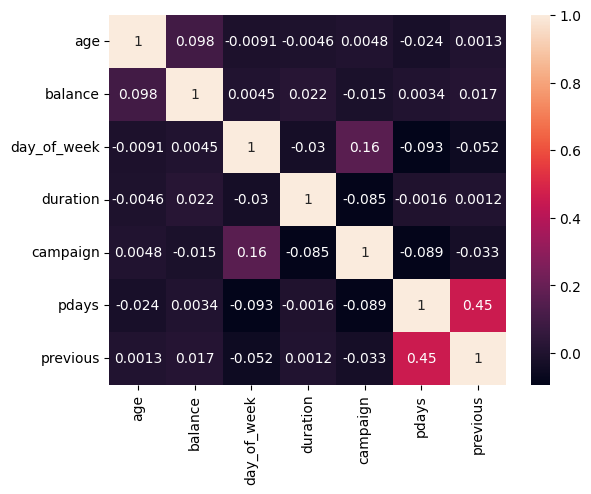

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

There are no strong correlations among the features.

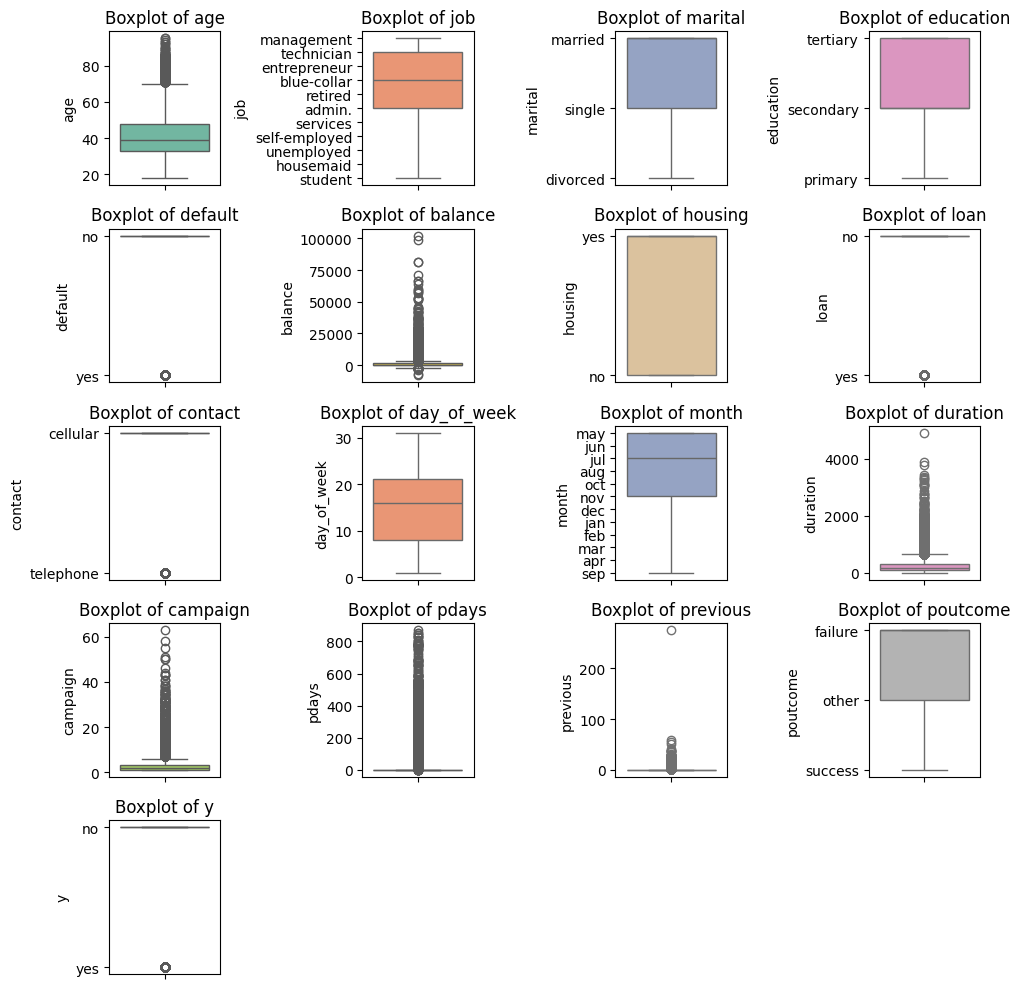

In [ ]:
palette = sns.color_palette("Set2", n_colors = len(df.columns))
plt.figure(figsize = (10,10))

for i, column in enumerate(df.columns, 1):
        plt.subplot(5,4,i) # Adjusted grid size to 5x4
        sns.boxplot(data = df[column], color = palette[i-1])
        plt.title(f"Boxplot of {column}")
        plt.xticks(rotation = 90)
        plt.tight_layout()
plt.show()

There are outliers on several features such as age, balance, and durations.

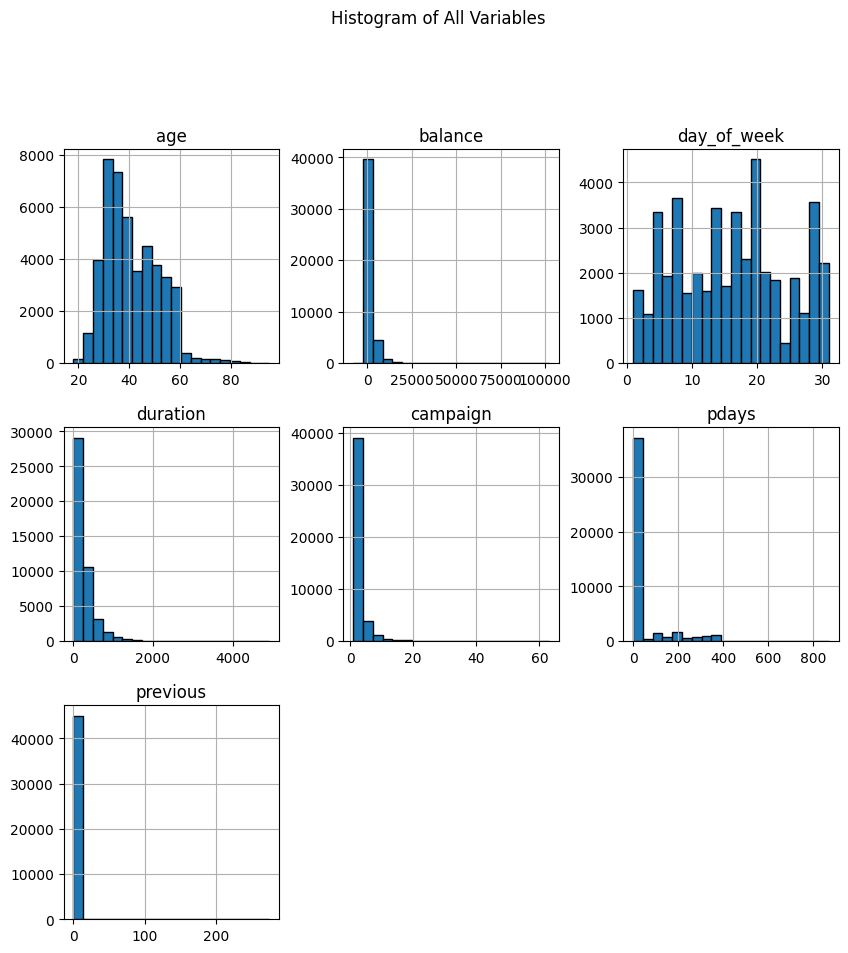

In [ ]:
df.hist(bins=20, figsize=(10, 10), edgecolor='black')
plt.suptitle('Histogram of All Variables', y=1.02)
plt.show()

The outlies strongly influence the distribution.

## 3. Data Preprocessing

In [ ]:
# Drop columns
# df_cleaned = df.drop(['contact', 'poutcome', 'duration'], axis=1)
df_cleaned = df.drop(['contact', 'poutcome'], axis=1)
df_cleaned.dropna(inplace=True)
df_cleaned = df_cleaned[df_cleaned['duration'] != 0]

# Remove outliers - apply only to numeric columns
numeric_cols_cleaned = df_cleaned.select_dtypes(include=np.number).columns
df_numeric = df_cleaned[numeric_cols_cleaned]

q1 = df_numeric.quantile(0.25)
q3 = df_numeric.quantile(0.75)
iqr = q3 - q1

# find locations of outliers in numeric columns
outlier_indices = df_numeric[(
    (df_numeric < (q1 - 1.5 * iqr)) | (df_numeric > (q3 + 1.5 * iqr))
)].dropna(how='all').index

# remove outliers from the original cleaned dataframe
df_outliers_cleaned = df_cleaned.drop(outlier_indices)


X = df_outliers_cleaned.drop('y', axis=1)
y = df_outliers_cleaned['y']
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26923 entries, 0 to 45209
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          26923 non-null  int64 
 1   job          26923 non-null  object
 2   marital      26923 non-null  object
 3   education    26923 non-null  object
 4   default      26923 non-null  object
 5   balance      26923 non-null  int64 
 6   housing      26923 non-null  object
 7   loan         26923 non-null  object
 8   day_of_week  26923 non-null  int64 
 9   month        26923 non-null  object
 10  duration     26923 non-null  int64 
 11  campaign     26923 non-null  int64 
 12  pdays        26923 non-null  int64 
 13  previous     26923 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.1+ MB


- The dataset contains missing values and outliers, which need to be addressed by removing or handling them appropriately.
- Since the dataset includes a mix of data types, all categorical (object) columns should be converted into dummy variables.

In [ ]:
# Transform all object columns into dummies and standardize all int64 (numeric) columns


# Automatically detect column types
numeric_cols = X.select_dtypes(include='int64').columns
categorical_cols = X.select_dtypes(include='object').columns

# Define the column transformer
preprocessor = ColumnTransformer(
   transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Fit and transform
X_processed = preprocessor.fit_transform(X)

# Get column names for one-hot encoded features
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine all column names
all_feature_names = list(numeric_cols) + list(encoded_cat_names)

# Create DataFrame with column names
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

# Check result
print(X_processed_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26923 entries, 0 to 26922
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  26923 non-null  float64
 1   balance              26923 non-null  float64
 2   day_of_week          26923 non-null  float64
 3   duration             26923 non-null  float64
 4   campaign             26923 non-null  float64
 5   pdays                26923 non-null  float64
 6   previous             26923 non-null  float64
 7   job_blue-collar      26923 non-null  float64
 8   job_entrepreneur     26923 non-null  float64
 9   job_housemaid        26923 non-null  float64
 10  job_management       26923 non-null  float64
 11  job_retired          26923 non-null  float64
 12  job_self-employed    26923 non-null  float64
 13  job_services         26923 non-null  float64
 14  job_student          26923 non-null  float64
 15  job_technician       26923 non-null 

- Lastly, all numerical features are standardized.

## 4. Feature Selection:


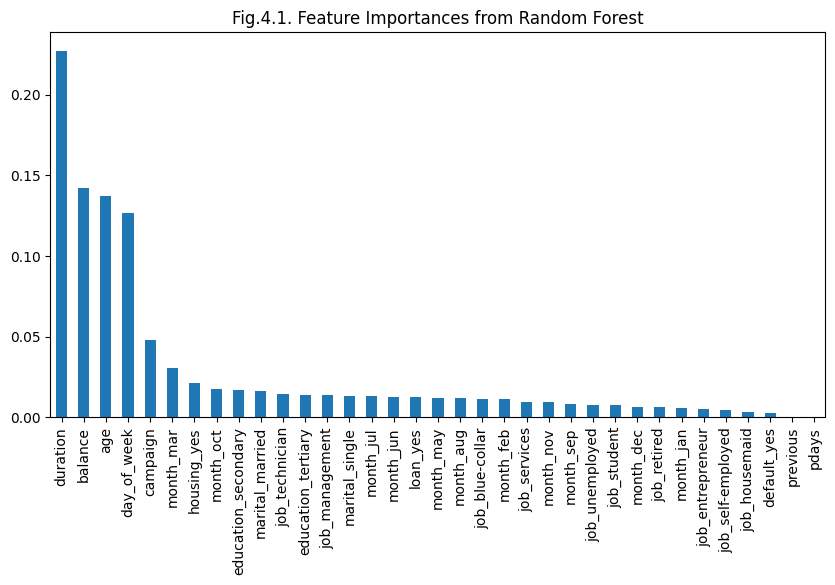

In [ ]:
# selecting features

X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Get feature importance scores
importances = rf.feature_importances_
features = X_processed_df.columns

# Put into a DataFrame for sorting
feat_importances = pd.Series(importances, index=features)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Fig.4.1. Feature Importances from Random Forest")
plt.show()


- Feature importance scores were obtained using a Random Forest model.

- As a result, variables such as duration, balance, age, and day_of_week received the highest importance scores.


In [ ]:
# Select top 10 features
# top_features = feat_importances.nlargest(10).index # columns names
indices = np.argsort(importances)[::-1]
top_indices = indices[:10]
X_train_selected = X_train.iloc[:, top_indices]
X_test_selected = X_test.iloc[:, top_indices]

# Use selected featrues in Logistic Regression

#log_reg = LogisticRegression()
#log_reg.fit(X_train_selected, y_train)
#y_pred = log_reg.predict(X_test_selected)

#print(classification_report(y_test, y_pred))

- The top 10 most important features were selected for modeling.

## 5. Model Selection


In [ ]:

smote = SMOTE(random_state=42)
X_train_selected_01, y_train_01 = smote.fit_resample(X_train_selected, y_train)
lb = LabelBinarizer()
y_train_bin_01 = lb.fit_transform(y_train_01).ravel()
y_test_bin = lb.transform(y_test).ravel()

# Check new balance
print(y.value_counts())
print(y_train_01.value_counts())

y
no     25416
yes     1507
Name: count, dtype: int64
y
no     17810
yes    17810
Name: count, dtype: int64


### Balancing labels

- The class "no" significantly outnumbers the class "yes" in the target variable y, indicating an imbalanced dataset.

- Imbalanced classes can cause models to become biased toward the majority class.

- Therefore, the dataset needs to be balanced using packages like SMOTE.

- References
  - [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      7606
           1       0.18      0.77      0.30       471

    accuracy                           0.79      8077
   macro avg       0.58      0.78      0.59      8077
weighted avg       0.94      0.79      0.84      8077


Rondom Forest Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7606
           1       0.32      0.32      0.32       471

    accuracy                           0.92      8077
   macro avg       0.64      0.64      0.64      8077
weighted avg       0.92      0.92      0.92      8077


SVC Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      7606
           1       0.19      0.73      0.30       471

    accuracy                           0.80      8077
   macro avg   

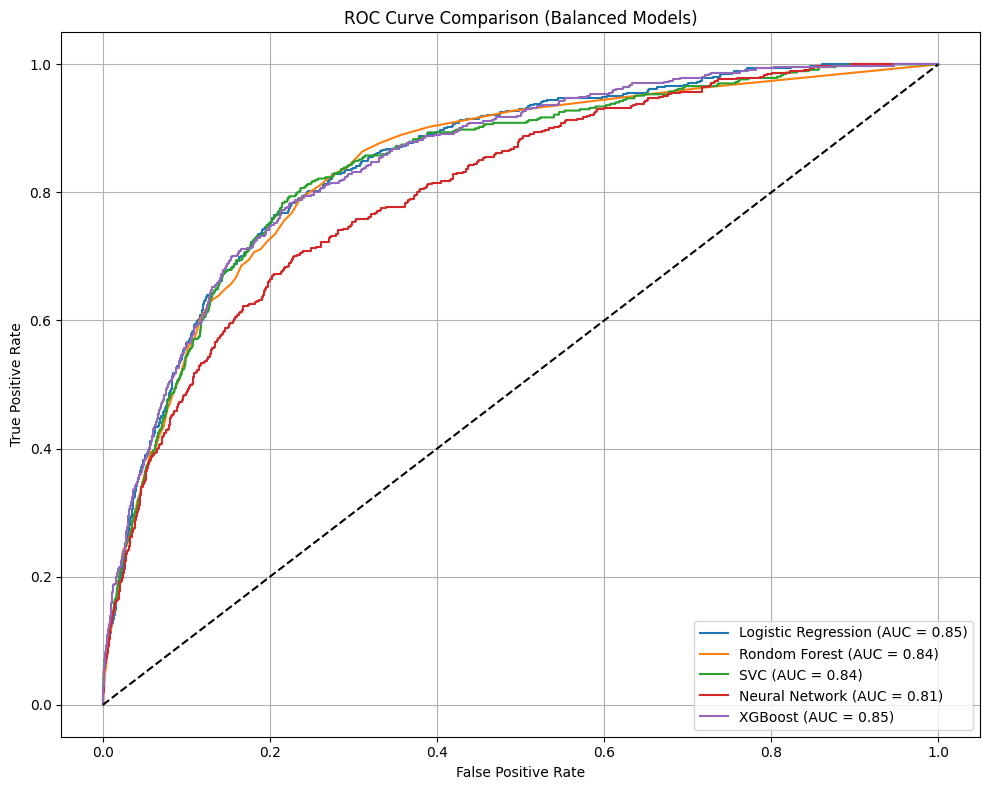

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Rondom Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "SVC": SVC(class_weight='balanced', probability=True),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='auc')
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_selected_01, y_train_bin_01)
    y_proba = model.predict_proba(X_test_selected)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    y_pred = model.predict(X_test_selected)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test_bin, y_pred))


# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--')

# Final ROC plot settings
plt.title('ROC Curve Comparison (Balanced Models)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Model selection

- Among the models compared, XGBoost achieved the highest AUC score, indicating that it most accurately distinguishes between "yes" and "no" classes.
- Therefore, the XGBoost model was selected for this project.



## 6. Model Building, Validation, and Testing

### Parameters
- The parameter values for the XGBoost model were selected through hyperparameter tuning.

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=500,
    verbosity=0
)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_selected_01, y_train_bin_01)
print("Best AUC:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best AUC: 0.993805420679777
Best parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


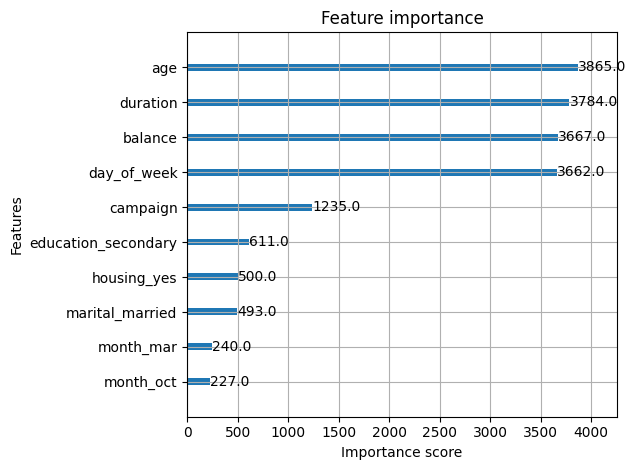

In [ ]:
# plot importance of each variable
from xgboost import plot_importance
plot_importance(random_search.best_estimator_)
plt.tight_layout()
plt.show()

### Model building

- Using the parameters, the model was built as accordingly.
- The model was validated using K-fold cross- validation, achieving an average score of 0.94.
- This indicates that the model performs well on the given data.

In [ ]:
# Define model
# model = LogisticRegression(class_weight='balanced', max_iter=1000)
# model = SVC(class_weight='balanced', probability=True)

model = XGBClassifier(
    # sub_sample=1.0,
    # reg_labmda=1,
    reg_alpha=0,
    min_child_weight=3,
    max_depth=7,
    gamma=0,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=500,
    colsample_bytree=1.0,
    seed = 46
)


In [ ]:
# K-fold cross validation

# Define K-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
# X_processed_df_selected = X_processed_df.iloc[:, top_indices]
scores = cross_val_score(model, X_test_selected, y_test_bin, cv=kf)

# Output results
print("Cross-validation scores:", scores)
print(f"Average score:, {scores.mean():.2f}")

Cross-validation scores: [0.9424505  0.93935644 0.93374613 0.92693498 0.9380805 ]
Average score:, 0.94


### Testing: Accuracy, precision, and recall

In [ ]:
# classification_report

model.fit(X_train_selected_01, y_train_bin_01)
y_pred = model.predict(X_test_selected)

y_probs = model.predict_proba(X_test_selected)[:, 1]
threshold = 0.7
y_pred_custom = (y_probs >= threshold).astype(int)

name = "Boosting"
name1 = "Boosting (threshold = " + str(threshold) + ")"

print(f"\n{name} Classification Report:\n")
print(classification_report(y_test_bin, y_pred))
print(f"\n{name1} Classification Report:\n")
print(classification_report(y_test_bin, y_pred_custom))


Boosting Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7606
           1       0.42      0.26      0.32       471

    accuracy                           0.94      8077
   macro avg       0.69      0.62      0.64      8077
weighted avg       0.92      0.94      0.93      8077


Boosting (threshold = 0.7) Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7606
           1       0.53      0.16      0.25       471

    accuracy                           0.94      8077
   macro avg       0.74      0.58      0.61      8077
weighted avg       0.93      0.94      0.93      8077



- With a threshold 0.5, the precision, recall and f1-score for the "yes" were 0.42, 0.26 and 0.32, respectively,
- These were relatively lower performance in identifying clients likely to subscribe.
- Given the nature of telemarketing, reducing calls to uninterested clients (precision) may be prioritized over maximizing campaign reach (recall).
- This is because fewer calls can reduce costs related to labor, telecommunications, and electricity, and also help prevent clients from feeling unconfortable or annoyed.
- To address this, the threshold was increased to 0.7 in an effort to improve precision. As a result, the precision rose to 0.53, while the recall droppted to 0.16.

#### Confusion matrix

In [ ]:
# Confusion matrix

print(f"\n# {name}\n")
# accuracy
accuracy = accuracy_score(y_test_bin, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
conf_matrix = confusion_matrix(y_test_bin, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\n# {name1}\n")
# accuracy
accuracy = accuracy_score(y_test_bin, y_pred_custom)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
conf_matrix1 = confusion_matrix(y_test_bin, y_pred_custom)
print("\nConfusion Matrix:")
print(conf_matrix1)


# Boosting

Accuracy: 0.94

Confusion Matrix:
[[7437  169]
 [ 350  121]]

# Boosting (threshold = 0.7)

Accuracy: 0.94

Confusion Matrix:
[[7538   68]
 [ 394   77]]


In [ ]:

labels = np.unique(y_test).tolist()

#fig = px.imshow(
#	conf_matrix,
#	text_auto=True,
#	color_continuous_scale="Blues",
#	labels=dict(x="Predicted Label", y="True Label", color="Count"),
#	x=labels,
#	y=labels
#)
#fig.update_layout(title="Boosting (threshold = 0.5)", width=400, height=400)
#fig.show()

fig1 = px.imshow(
	conf_matrix1,
	text_auto=True,
	color_continuous_scale="Blues",
	labels=dict(x="Predicted Label", y="True Label", color="Count"),
	x=labels,
	y=labels
)

fig1.update_layout(title="Fig.6.1. Boosting (threshold = 0.7)", width=400, height=400)
fig1.show()

- In the positive predictions, there were 77 true positives and 68 false positives. This means that if operators call these 145 clients from the test dataset, they would successfully reach 77 clients who are actually interested in the term deposit, while incurring labor and other related costs for all 145 clients.

- On the other hand, the model missed 394 potential clients, as indicated by the false negatives.

## 7. Answer a set of business questions that they deﬁned in their proposal by applying the selected model.

### 1. What variables are strongly associated with the success of telemarketing?

- According to Fig.4.1, the most important variables includes duration, balance, age, day_of_week, campaign, among others. In perticular, the duration of the last call, bank balance, age and the day of the week are likely to be influencial factors. However, a model excluding duration might be more appropriate, since the duration is only known after the call is completed in the real situation (UCI data repository).

### 2. How accurately can we predict which clients are likely to subscribe?

- The accuracy of the model was 0.94, suggesting that its overall performance is not poor, especially given that the majority class is "no". However, the precision, recall and F1-score for the "yes" were 0.53, 0.16 and 0.25, respectively. These scores indicates that the model performs poorly in identifying clients who are likely to subscribe.

## 8. Business Impact Analysis: Analyze the potential business impact of their model with some assumptions on the costs and beneﬁts of predictions.

- Operators would be able to reach clients who are actually interested in the term deposit in about one out of two calls.

- Reducing the number of calls can help cut costs related to labor, telecommunications, and electricity, and also help prevent clients from feeling unconfortable or annoyed.

- However, since the model still missed 84% of potential clients, as indicated by the recall score, a second model should be developed using remaining dataset, exluding those alreadly predicted as positive.

- Building a second model may help indentify additional true positives among the remaining clients, potentially increasing the number of subscribers while minimizing associated costs.


### References
Moro, S., Cortez, P., & Rita, P. (2014). A data-driven approach to predict the success of bank telemarketing. Decis. Support Syst., 62, 22-31.